# Action Priors in 1D

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import datetime

from IPython.core.debugger import set_trace

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# load env
from src.envs.LinearEnv import LinearEnv


# cell magic for reloading imported modules
%load_ext autoreload

## Environment
- State: 
    - $s \in \mathbb{R}^{(1)}$
- Simulates a frog jumping over pools of lava in 1D.
- Should use 1D arrays for states and actions, etc.

In [3]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

## Random Agent

In [4]:
# random agent
def random_agent(obs):
    return {"Action":np.random.uniform(-0.3,0.3,size=(1,))}

In [5]:
# run a single episode for an agent in the environment and return the rollout

def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []


    done = False
    obs = env.reset()
    for i in range(max_steps):
        observation_list.append(obs.copy())
        out = agent(obs)
        
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action.copy())
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

In [6]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))
def returns(rewards):
    return np.sum(rewards)

$$
\large \nabla_{\theta}J(\theta) \approx \frac{1}{N}\sum \limits_{i = 1}^{N}\left( \sum \limits_{t = 1}^{T} \nabla_{\theta}log\pi_{\theta}(s_{i,t}\mid a_{i,t})\right)\left( \sum \limits_{t = 1}^{T}r(s_{i,t},a_{i,t}) - b\right)
$$

In [7]:
def loss_pg(log_probs, returns):
    
    log_probs = tf.reduce_sum(log_probs, axis=0)
    
    if np.ndim(returns) > 1:
        returns = np.sum(returns, axis = 1)
    else:
        returns = np.sum(returns)
    
    return -tf.reduce_mean(returns * log_probs)

## Training Loop

In [13]:
def train_policy_grad(env, agent, num_epochs=300):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/' + current_time + '/train'
    # test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
       
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    log_reward = 0
    log_reward_list = []
    logging_period = 10
    
    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]
        
        # compute 'reward-to-go'
        rew_2_go = reward_to_go(rew)
        
        # compute gradients + update weights
        with tf.GradientTape() as tape:
            out = agent(obs)
            log_probs = out["LogProbability"] 

            if np.min(log_probs) < -1e5:
                print('#################')
                tf.print("Log prob too small", log_probs, summarize=6)
                tf.print( "Scale is:", agent(obs)["Scale"])
            loss = loss_pg(log_probs, rew_2_go)
            
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss, step=epoch)
            tf.summary.histogram("Action", tf.reduce_mean(out["Action"]) , step=epoch)
            tf.summary.histogram("LogProbability", tf.reduce_mean(out["LogProbability"]) , step=epoch)
            tf.summary.histogram("Sigma", tf.reduce_mean(out["Scale"]) , step=epoch)
            tf.summary.histogram("Mu", tf.reduce_mean(out["Loc"]) , step=epoch)
            
            for i,g in enumerate(gradients):
                tf.summary.histogram("gradient_"+str(i),tf.reduce_mean(g), step=epoch)

        
        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
            #set_trace()
       
    return (range(0, num_epochs, logging_period), log_reward_list)

Training Epoch 0, Averaged Return: -94.01596069335938
> <ipython-input-13-ad4f1e49eea7>(12)train_policy_grad()
     10     logging_period = 10
     11 
---> 12     for epoch in range(num_epochs):
     13         # get the training data
     14         traj = get_episode_trajectory(env, agent)

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Training Epoch 10, Averaged Return: -714.4274444580078
> <ipython-input-13-ad4f1e49eea7>(12)train_policy_grad()
     10     logging_period = 10
     11 
---> 12     for epoch in range(num_epochs):
     13         # get the training data
     14         traj = get_episode_trajectory(env, agent)

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Training Epoch 20, Averaged Return: -818.38203125
> <ipython-input-13-ad4f1e49eea7>(12)train_policy_grad()
     10     logging_period = 10
     11 
---> 12     for epoch in range(num_epochs):
     13         # get the training data
     14         traj = get_episode_trajectory(env, ag

BdbQuit: 

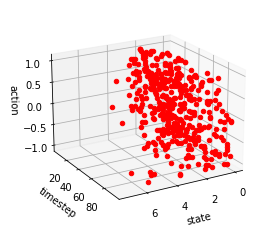

In [14]:
# load agent
from src.agents.AgentMLPTF import AgentMLPTF

agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env, agent_mlp_tf)

In [10]:
len(agent_mlp_tf.trainable_variables)

6

In [10]:
s = env.reset()
print(np.array(s.ndim))
eps = 300
states = []
rewards_1 = []
for i in range(eps):
    traj = get_episode_trajectory(env, random_agent)
    rewards_1.append(np.sum(traj["Rewards"]))
    

1


In [11]:

plt.plot(episodes, rewards, label="REINFORCE")
plt.plot(episodes, rewards_1, label="Random")
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.legend()
plt.show()

NameError: name 'episodes' is not defined

1


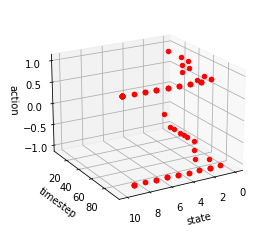

In [33]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

s = env.reset()
print(np.array(s.ndim))
eps = 100
states = []

for i in range(eps):
    a = agent_mlp_tf(s)["Action"]
    s,r,done,_ = env.step(a)
    states.append(np.array([s,a]))

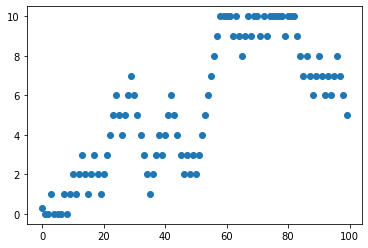

In [34]:
arr = np.array(states)
plt.scatter(list(range(arr.shape[0])),arr[:,0])

(array([ 1.,  0.,  1.,  2.,  6., 83.,  3.,  1.,  1.,  2.]),
 array([-4.00917413e+13, -3.20863379e+13, -2.40809346e+13, -1.60755312e+13,
        -8.07012779e+12, -6.47244022e+10,  7.94067898e+12,  1.59460824e+13,
         2.39514858e+13,  3.19568891e+13,  3.99622925e+13]),
 <BarContainer object of 10 artists>)

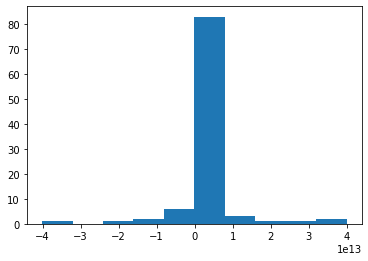

In [35]:
plt.hist(arr[:,1])

In [36]:
arr[:,1]

array([[-7.03915238e-01],
       [-1.01702347e+01],
       [-2.12331128e+00],
       [ 6.47586727e+00],
       [-4.71448250e+01],
       [-2.18988752e+00],
       [-1.76731420e+00],
       [ 7.81501007e+00],
       [-4.78580093e+01],
       [ 2.46193314e+00],
       [ 1.61350525e+02],
       [-7.61021179e+02],
       [ 7.16895370e+01],
       [ 1.87057874e+03],
       [-3.09903589e+03],
       [-7.09151489e+02],
       [ 2.16203354e+02],
       [ 2.99216766e+02],
       [-2.52753672e+04],
       [-1.64847168e+03],
       [ 1.59412704e+02],
       [ 9.50809570e+02],
       [ 4.93244727e+04],
       [ 5.08989688e+05],
       [ 7.78718812e+05],
       [-6.10330400e+07],
       [-5.43574550e+06],
       [ 1.22440992e+05],
       [ 2.48543600e+07],
       [ 6.43377080e+07],
       [-3.83790438e+09],
       [-3.09335232e+08],
       [-6.41957312e+05],
       [-4.95599938e+05],
       [-1.11792588e+04],
       [-1.30462793e+03],
       [ 2.68127380e+02],
       [ 2.10981201e+03],
       [ 5.5